In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Primero instalamos el entorno de Frozen Lake

In [2]:
!pip install -q gym matplotlib

Importamos las bibliotecas necesarias

In [3]:
import gym #para el juego
import random #para generar números aleatorios
import numpy as np #para hacer algunos cálculos

Definición de estados:

- S: starting point, safe
- F: frozen surface, safe
- H: hole, stuck forever
- G: goal, safe

In [4]:
# Inicializar el entorno no resbaladizo de Frozen Lake
environment = gym.make("FrozenLake-v1",render_mode="ansi", is_slippery=False)
environment.reset()
environment.render()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


['\n\x1bS\x1bFFF\nFHFH\nFFFH\nHFFG\n']

Tenemos 16 estados y 4 acciones, así que queremos calcular 64 valores.

Vamos a crear nuestra tabla Q y llenarla con ceros ya que aún no tenemos idea del valor de cada acción en cada estado.

In [5]:
# Inicializar Q-table con ceros
# Nuestra "table" tiene las siguientes dimensiones:
# (filas x columnas) = (estados x acciones) = (16 x 4)
qtable = np.zeros((16, 4))

# Alternativamente, la biblioteca "gym" también puede directamente darnos el número de estados y acciones usando
# "env.observation_space.n" y "env.action_space.n"
nb_states = environment.observation_space.n  # = 16
nb_actions = environment.action_space.n      # = 4
qtable = np.zeros((nb_states, nb_actions))

# Veamos cómo se ve
print('Q-table =')
print(qtable)

Q-table =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


Tenemos nuestra tabla Q con 16 filas (nuestros 16 estados) y 4 columnas (nuestras 4 acciones) como esperábamos.

Cada valor se establece en cero, por lo que no tenemos ninguna información. Digamos que el agente realiza una acción aleatoria. Podemos usar la biblioteca "random" con el método "choice" para elegir aleatoriamente una acción.

In [6]:
random.choice(["LEFT", "DOWN", "RIGHT", "UP"])

'LEFT'

En realidad el agente se encuentra actualmente en el estado inicial S, lo que significa que solo son posibles dos acciones:
- DERECHA y ABAJO
- ARRIBA e IZQUIERDA
pero no se moverá: su estado no cambia. Por lo tanto, no imponemos ninguna restricción sobre qué acciones son posibles: el agente comprenderá naturalmente que algunas de ellas no hacen nada.

Podemos seguir usando random.choice(), pero la biblioteca "gym" ya implementa un método para elegir aleatoriamente una acción. Podría ahorrarnos algunos problemas más adelante, así que lo hacemos así.

In [7]:
environment.action_space.sample()

1

Esta vez es un número. Los números se conectan con las direcciones de la siguiente manera:
- LEFT: 0
- DOWN: 1
- RIGHT: 2
- UP: 3

Vamos a mover a nuestro agente a la derecha. Esta vez, se puede realizar utilizando el método "step(action)". Podemos probar a proporcionarle directamente el número 2, correspondiente a la dirección que elegimos (derecha), y comprobar si el agente se ha movido.

In [8]:
environment.step(2)
environment.render()

['  (Right)\nS\x1bF\x1bFF\nFHFH\nFFFH\nHFFG\n']

Se ha movido desde el estado inicial S hacia la derecha.

Lo que necesitamos saber para interactuar con el entorno es:
- Cómo elegir aleatoriamente una acción usando action_space.sample()
- Cómo implementar esta acción y mover a nuestro agente en la dirección deseada con step(action)

Podemos agregar también:
- Cómo mostrar el mapa actual para ver lo que estamos haciendo con render()
- Cómo reiniciar el juego cuando el agente cae en un hoyo o llega a la meta G con reset()

Los agentes son recompensados por el entorno cuando logran un objetivo predefinido. En Frozen Lake, el agente solo es recompensado cuando alcanza el estado G. Esta recompensa no la podemos controlar, está configurada en el entorno: devuelve 1 cuando el agente llega a G, y 0 en caso contrario.

Vamos a imprimirlo cada vez que implementemos una acción. La recompensa la da el método "step(action)".

In [9]:
# 1. Elegir aleatoriamente una acción utilizando action_space.sample()
action = environment.action_space.sample()

# 2. Implementar esta acción y mover el agente en la dirección deseada
new_state, reward, done, info = environment.step(action)

# Mostramos los resultados (recompensa y mapa)
environment.render()
print(f'Reward = {reward}')

Reward = 0.0


Si alguna vez queremos ver una recompensa de 1, debemos tener la suerte de encontrar la secuencia correcta de acciones por casualidad. Así es exactamente como funciona, la tabla Q permanecerá llena de ceros hasta que el agente alcance aleatoriamente la meta G.

El problema sería mucho más sencillo si pudiéramos tener recompensas intermedias más pequeñas para guiar nuestro camino hacia la meta G .

Este es en realidad uno de los principales problemas del aprendizaje por refuerzo. Este fenómeno, llamado recompensas escasas, hace que sea muy difícil capacitar a los agentes en problemas en los que la única recompensa se encuentra al final de una larga secuencia de acciones.

¿Cómo retropropagar la información al estado inicial?
- Necesitamos actualizar el valor de nuestros pares estado-acción (cada celda en la tabla Q) considerando 1: la recompensa por alcanzar el siguiente estado y 2: el valor más alto posible en el siguiente estado.

Entonces entrenar a nuestro agente en código significa:
- Elegir una acción aleatoria (usando action_space.sample()) si los valores en el estado actual son solo ceros. De lo contrario, tomamos la acción con el valor más alto en el estado actual con la función np.argmax()
- Implementando esta acción moviéndose en la dirección deseada con step(action)
- Actualizar el valor del estado original con la acción que realizamos, utilizando información sobre el nuevo estado y la recompensa otorgada por step(action)

Seguimos repitiendo estos 3 pasos hasta que el agente se atasca en un agujero o alcanza la meta G.

Podemos graficar el resultado de cada ejecución para observar el progreso de nuestro agente.

Q-table before training:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Q-table after training:
[[0.      0.59049 0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.6561  0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.729   0.     ]
 [0.      0.81    0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.9     0.     ]
 [0.      0.      1.      0.     ]
 [0.      0.      0.      0.     ]]


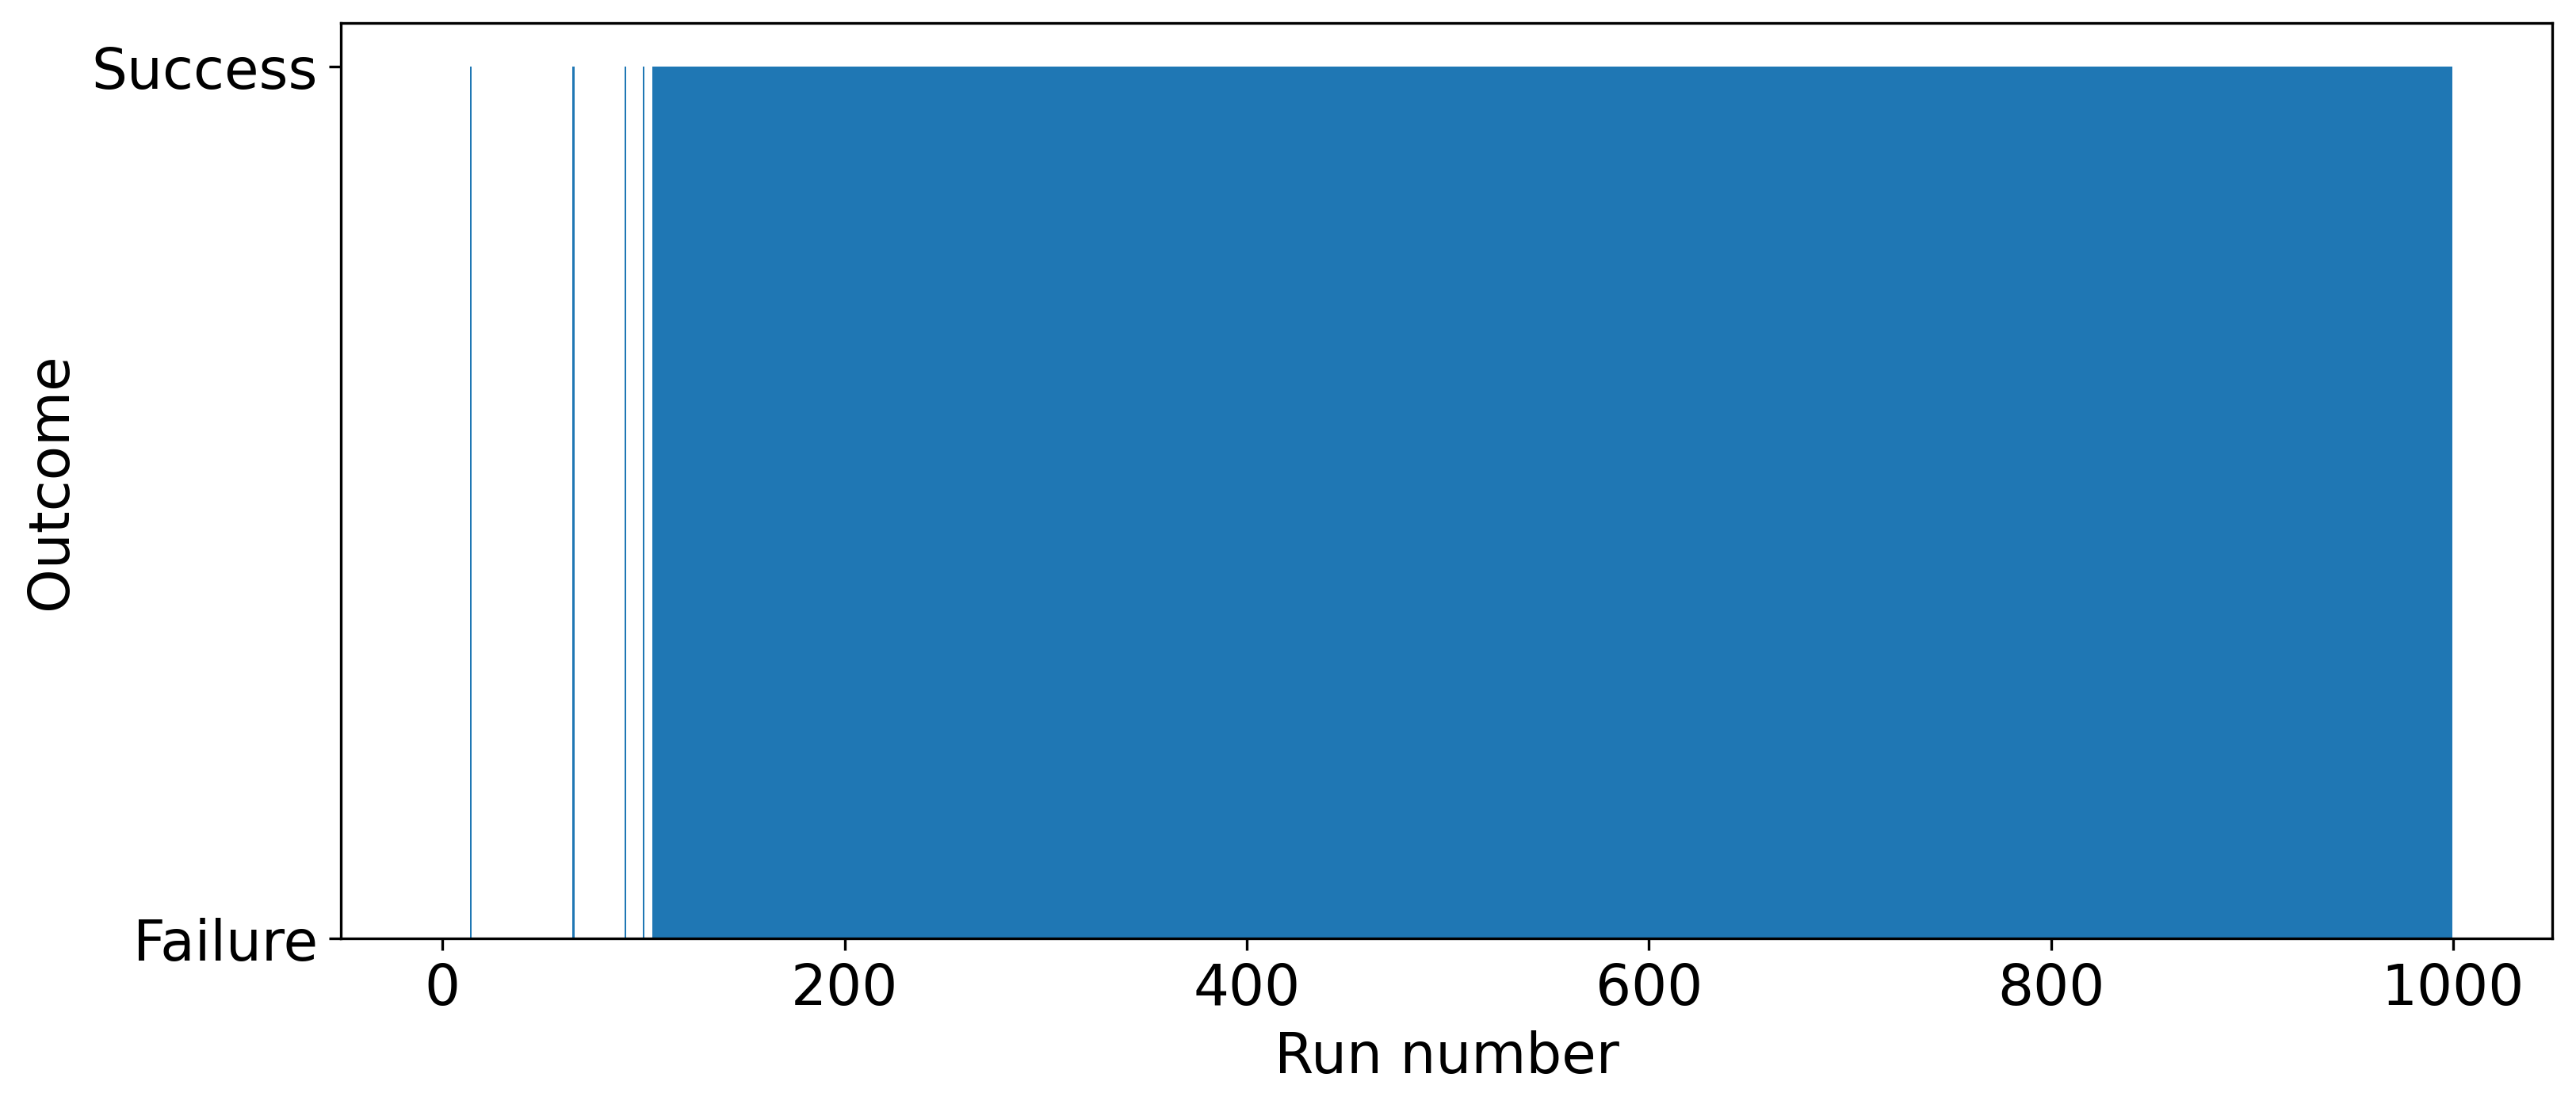

In [10]:
# Importar matplotlib para trazar los resultados
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 17})

# Reinicializamos la Q-table
qtable = np.zeros((environment.observation_space.n, environment.action_space.n))

# Hiperparámetros
episodes = 1000        # Número total de episodios
alpha = 0.5            # Tasa de aprendizaje
gamma = 0.9            # Factor de descuento

# Lista de resultados para trazar
outcomes = []

print('Q-table before training:')
print(qtable)

# Entrenamiento
for _ in range(episodes):
    state = environment.reset()
    done = False

    # Por defecto, consideramos que nuestro resultado es un fracaso.
    outcomes.append("Failure")

    # Hasta que el agente se quede atrapado en un hoyo o alcance la meta, sigue entrenándolo
    while not done:
        # Elija la acción con el valor más alto en el estado actual
        if np.max(qtable[state]) > 0:
          action = np.argmax(qtable[state])

        # Si no hay una mejor acción (solo ceros), elige una al azar
        else:
          action = environment.action_space.sample()

        # Implemente esta acción y mueva el agente en la dirección deseada.
        new_state, reward, done, info = environment.step(action)

        # Actualizar Q(s, a)
        qtable[state, action] = qtable[state, action] + \
                                alpha * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])

        # Actualizar nuestro estado actual
        state = new_state

        # Si tenemos una recompensa, significa que nuestro resultado es un éxito.
        if reward:
          outcomes[-1] = "Success"

print()
print('===========================================')
print('Q-table after training:')
print(qtable)

# Plot outcomes
plt.figure(figsize=(12, 5))
plt.xlabel("Run number")
plt.ylabel("Outcome")
ax = plt.gca()
plt.bar(range(len(outcomes)), outcomes, width=1.0)
plt.show()

Para ver cómo se desempeña el agente, podemos calcular el porcentaje de veces que logró alcanzar la meta (tasa de éxito)

In [11]:
episodes = 100
nb_success = 0

# Evaluación
for _ in range(100):
    state = environment.reset()
    done = False

    # Hasta que el agente se atasque o alcance la meta, sigue entrenándolo
    while not done:
        # Elija la acción con el valor más alto en el estado actual
        if np.max(qtable[state]) > 0:
          action = np.argmax(qtable[state])

        # Si no hay una mejor acción (solo ceros), elegimos una al azar
        else:
          action = environment.action_space.sample()

        # Implementamos esta acción y movemos el agente en la dirección deseada.
        new_state, reward, done, info = environment.step(action)

        # Actualizar nuestro estado actual
        state = new_state

        # Cuando recibimos una recompensa, significa que resolvimos el juego.
        nb_success += reward

# ¡Revisemos nuestra tasa de éxito!
print (f"Success rate = {nb_success/episodes*100}%")

Success rate = 100.0%


Podemos visualizar al agente moviéndose en el mapa ejecutando el siguiente código e imprimir la secuencia de acciones que tomó para verificar si es la mejor.

In [12]:
from IPython.display import clear_output
import time

state = environment.reset()
done = False
sequence = []

while not done:
    # Elija la acción con el valor más alto en el estado actual
    if np.max(qtable[state]) > 0:
      action = np.argmax(qtable[state])

    # Si no hay una mejor acción (solo ceros), elige una al azar
    else:
      action = environment.action_space.sample()

    # Añade la acción a la secuencia.
    sequence.append(action)

    # Implementamos esta acción y movemos el agente en la dirección deseada.
    new_state, reward, done, info = environment.step(action)

    # Actualizar nuestro estado actual
    state = new_state

    # Actualizar el renderizado
    clear_output(wait=True)
    environment.render()
    time.sleep(1)

print(f"Sequence = {sequence}")

Sequence = [1, 1, 2, 1, 2, 2]


Queremos permitir que nuestro agente:
- Tome la acción con el valor más alto (explotación)
- Elija una acción aleatoria para intentar encontrar otras aún mejores (exploración)

Queremos una compensación entre estos dos comportamientos.

Si el agente solo realiza acciones aleatorias, el entrenamiento no tiene sentido ya que no utiliza la tabla Q. Por eso queremos cambiar este parámetro con el tiempo: al comienzo del entrenamiento, queremos explorar el entorno tanto como sea posible. Pero la exploración se vuelve cada vez menos interesante, ya que el agente ya conoce todos los posibles pares estado-acción. Este parámetro representa la cantidad de aleatoriedad en la selección de acciones.

Esta técnica se denomina comúnmente algoritmo ávido de épsilon , donde épsilon es nuestro parámetro. Es un método simple pero extremadamente eficiente para encontrar una buena compensación. Podemos disminuir el valor de épsilon al final de cada episodio en una cantidad fija (decaimiento lineal) o en función del valor actual de épsilon (decaimiento exponencial).

Implementemos un decaimiento lineal.

Q-table before training:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Q-table after training:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


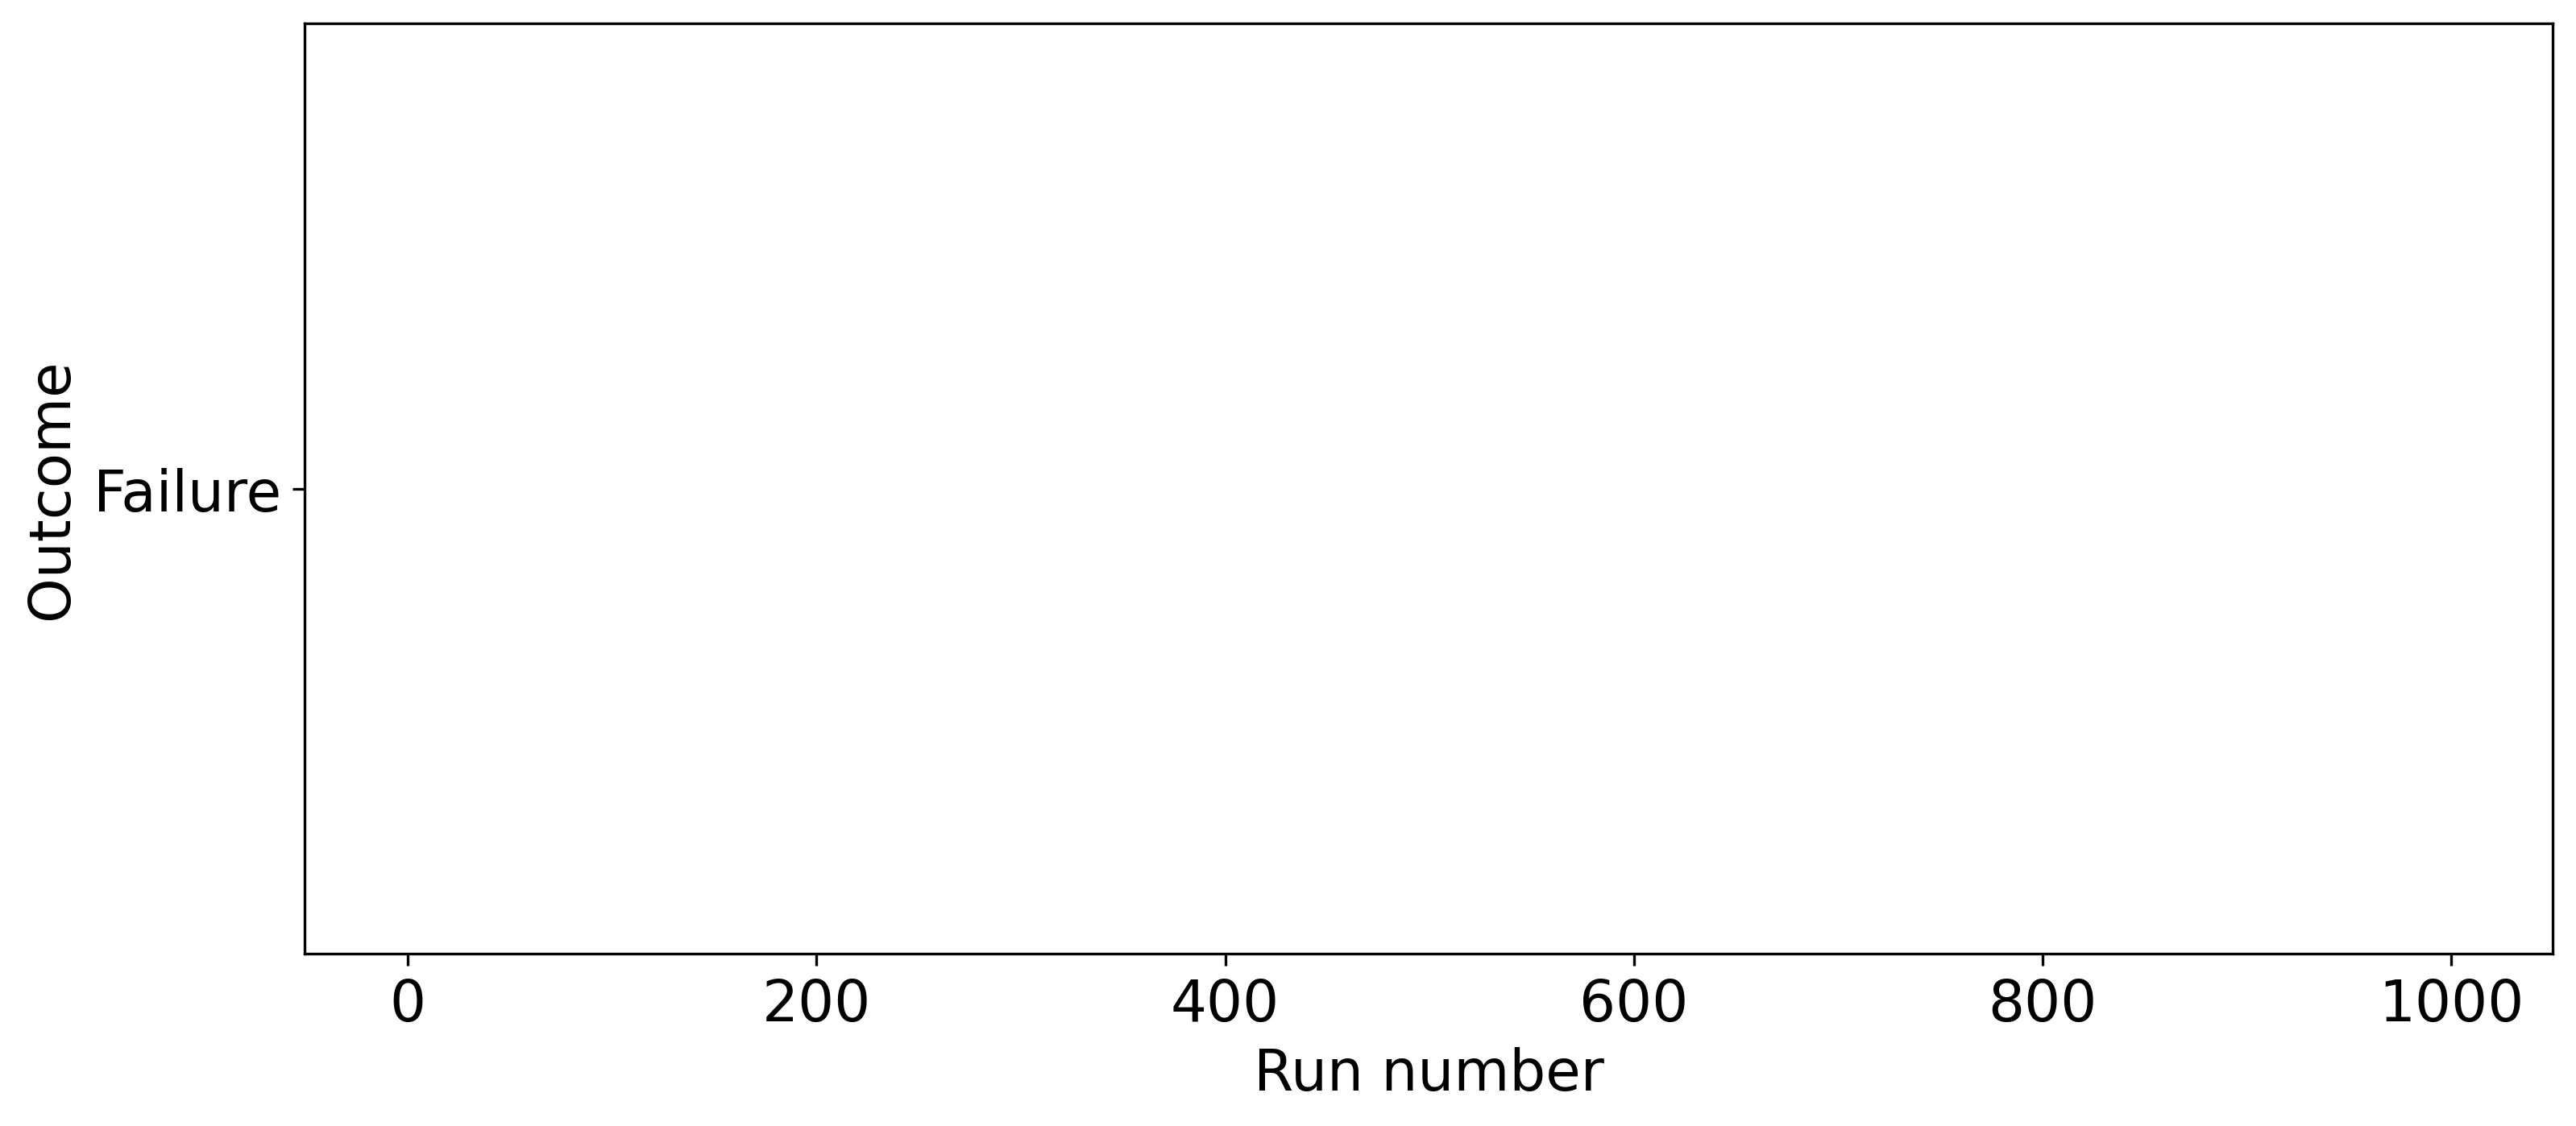

In [13]:
# Reinicializamos la Q-table
qtable = np.zeros((environment.observation_space.n, environment.action_space.n))

# Hiperparámetros
episodes = 1000        # Número total de episodios
alpha = 0.5            # Tasa de aprendizaje
gamma = 0.9            # Factor de descuento
epsilon = 1.0          # Cantidad de aleatoriedad en la selección de acciones.
epsilon_decay = 0.001  # Cantidad fija a disminuir

# Lista de resultados para trazar
outcomes = []

print('Q-table before training:')
print(qtable)

# Entrenamiento
for _ in range(episodes):
    state = environment.reset()
    done = False

    # Por defecto, consideramos que nuestro resultado es un fracaso.
    outcomes.append("Failure")

    # Hasta que el agente se quede atrapado en un agujero o alcance la meta, sigue entrenándolo
    while not done:
        # Genera un número aleatorio entre 0 y 1
        rnd = np.random.random()

        # Si el número aleatorio < épsilon, realiza una acción aleatoria
        if rnd < epsilon:
          action = environment.action_space.sample()
        # De lo contrario, realice la acción con el valor más alto en el estado actual.
        else:
          action = np.argmax(qtable[state])

        # Implementamos esta acción y movemos el agente en la dirección deseada.
        new_state, reward, done, info = environment.step(action)

        # Actualizamos Q(s,a)
        qtable[state, action] = qtable[state, action] + \
                                alpha * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])

        # Actualizar nuestro estado actual
        state = new_state

        # Si tenemos una recompensa, significa que nuestro resultado es un éxito.
        if reward:
          outcomes[-1] = "Success"

    # Actualizar épsilon
    epsilon = max(epsilon - epsilon_decay, 0)

print()
print('===========================================')
print('Q-table after training:')
print(qtable)

# Plot outcomes
plt.figure(figsize=(12, 5))
plt.xlabel("Run number")
plt.ylabel("Outcome")
ax = plt.gca()
plt.bar(range(len(outcomes)), outcomes, width=1.0)
plt.show()

El agente ha aprendido varias secuencias de acciones para alcanzar la meta. Es comprensible, ya que este nuevo agente se ve obligado a explorar pares estado-acción en lugar de explotar siempre los que tienen valores distintos de cero.

A ver si tiene tanto éxito como el anterior para ganar la partida. En el modo de evaluación, ya no queremos exploración porque el agente ya está capacitado.

In [14]:
episodes = 100
nb_success = 0

# Evaluación
for _ in range(100):
    state = environment.reset()
    done = False

    # Hasta que el agente se atasque o alcance la meta, sigue entrenándolo
    while not done:
        # Elija la acción con el valor más alto en el estado actual
        action = np.argmax(qtable[state])

        # Implemente esta acción y mueva el agente en la dirección deseada.
        new_state, reward, done, info = environment.step(action)

        # Actualizar nuestro estado actual
        state = new_state

        # Cuando recibimos una recompensa, significa que resolvimos el juego.
        nb_success += reward

# ¡Revisemos nuestra tasa de éxito!
print (f"Success rate = {nb_success/episodes*100}%")

Success rate = 0.0%


No degradamos el modelo. Los beneficios de este enfoque pueden no ser obvios en este ejemplo, pero nuestro modelo se volvió menos estático y más flexible . Aprendió diferentes caminos (secuencias de acciones) de S a G en lugar de solo uno como en el enfoque anterior. Más exploración puede degradar el rendimiento, pero es necesario formar agentes que puedan adaptarse a nuevos entornos.

No resolvimos todo el entorno de Frozen Lake, solo entrenamos a un agente en la versión antideslizante, usando is_slippery = False durante la inicialización. Veamos qué tan bien le está yendo a nuestro código en este nuevo entorno.

Q-table before training:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Q-table after training:
[[0.04488661 0.04389136 0.05783787 0.03842703]
 [0.03144692 0.03292572 0.03393382 0.05005248]
 [0.01911058 0.03122024 0.0229558  0.02309574]
 [0.01427316 0.00875512 0.0097195  0.02520517]
 [0.07941798 0.05734676 0.03222691 0.05017626]
 [0.         0.         0.         0.        ]
 [0.08043048 0.00876833 0.01147609 0.0112772 ]
 [0.         0.         0.         0.        ]
 [0.00268953 0.0483123  0.1694424  0.10553561]
 [0.09050274 0.40116873 0.05826768 0.05958939]
 [0.07507791 0.07983437 0.08481634 0.2306442 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.09506491 0.12700584 0.39861324 0.0472828 ]
 [0.27339727 0.3223653  0.66569959 0.28481144]
 [0.

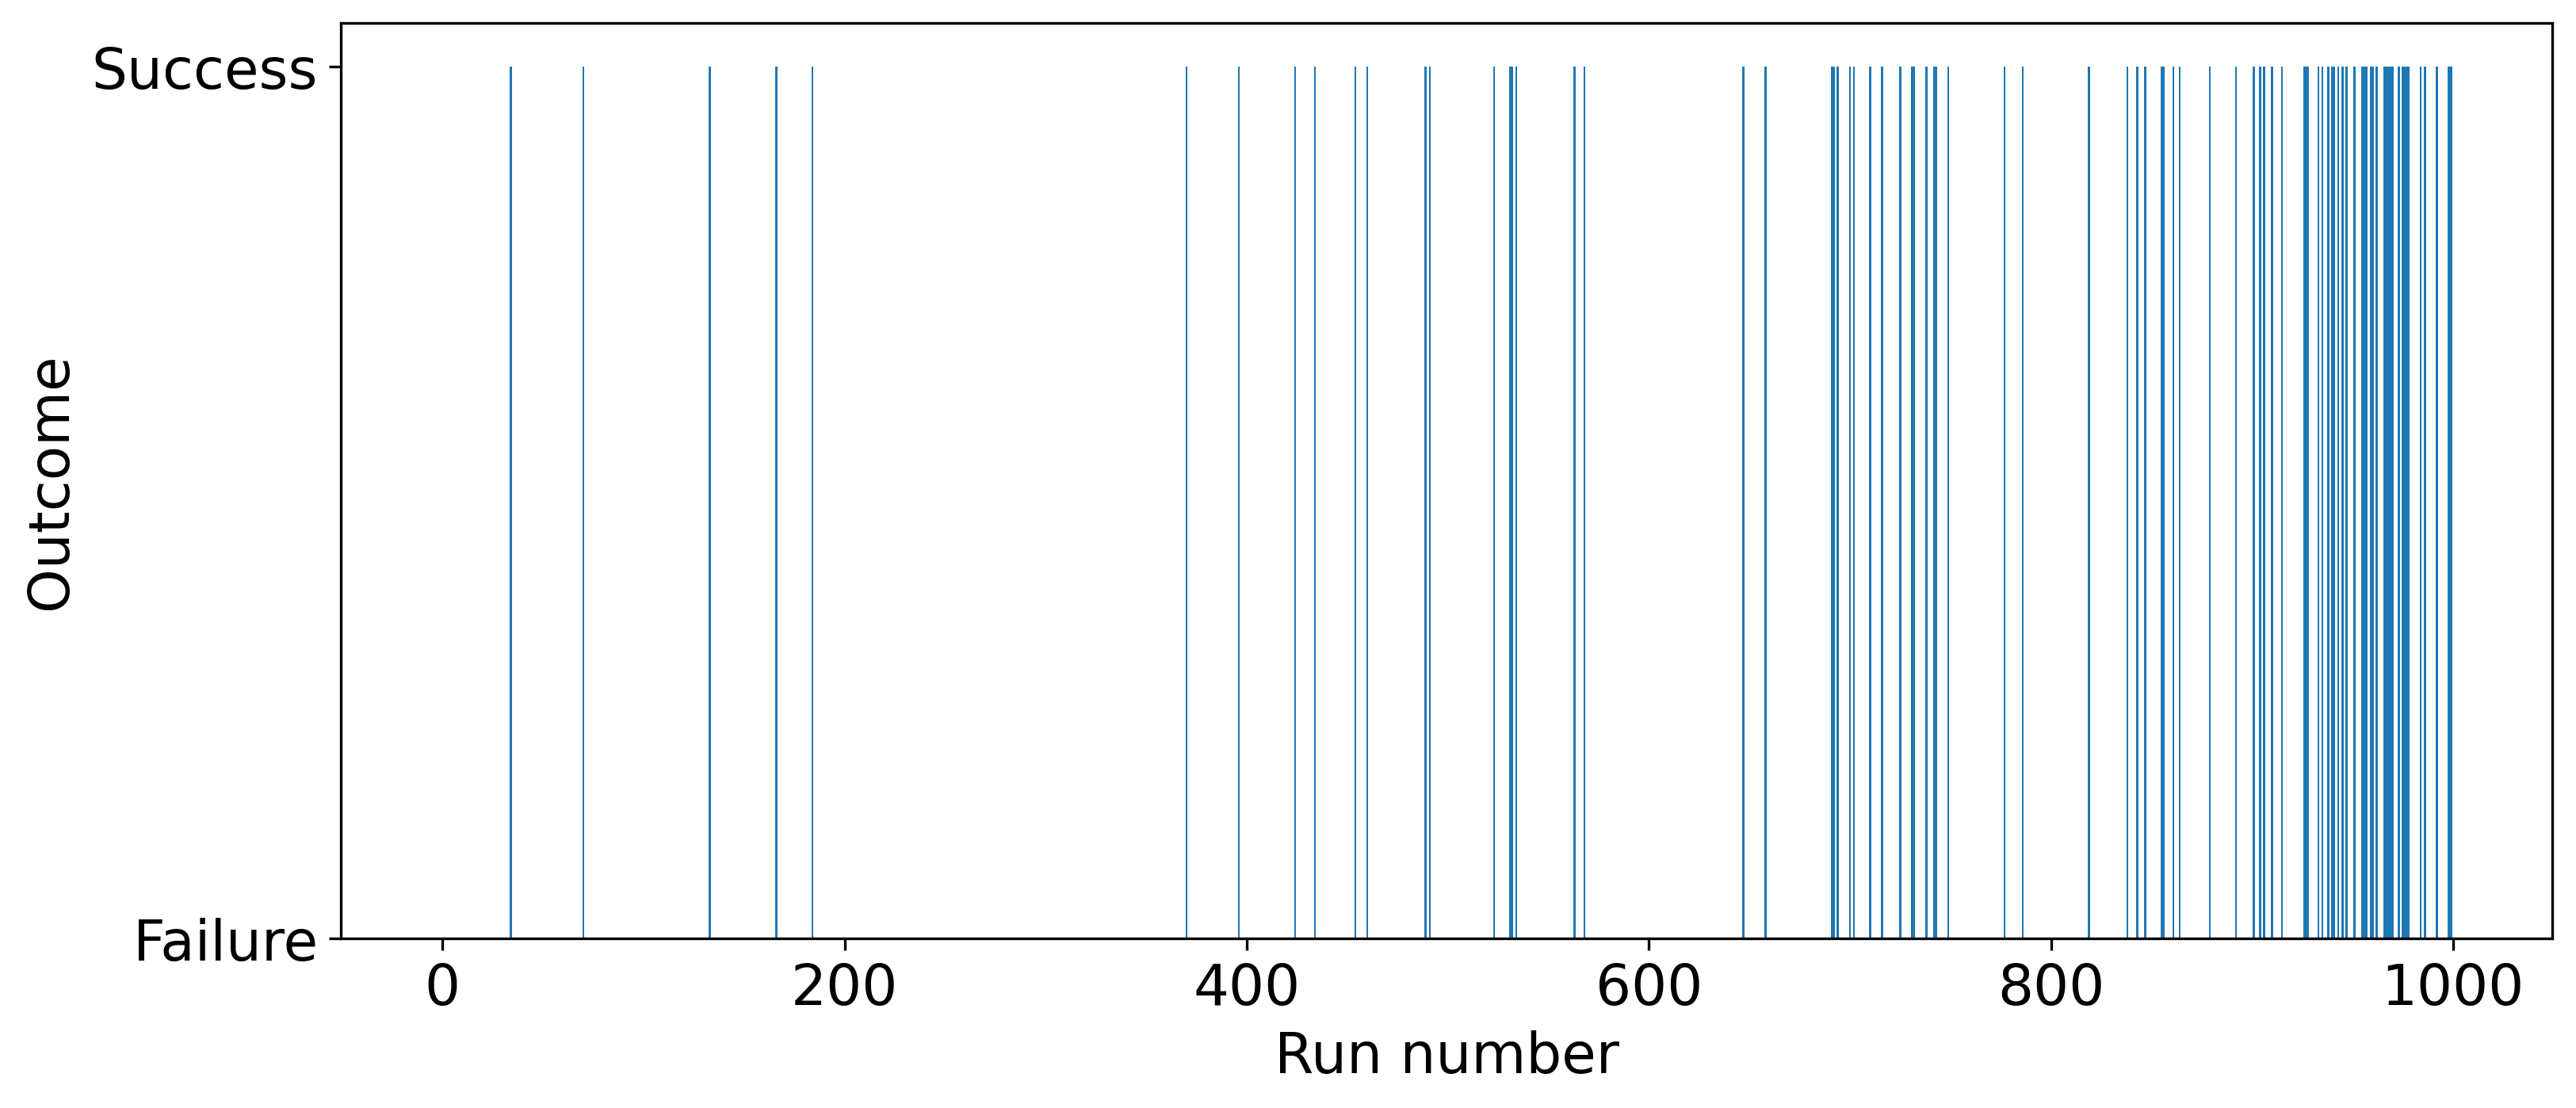

Success rate = 4.0%


In [15]:
# Inicializa el resbaladizo lago congelado
environment = gym.make("FrozenLake-v1", is_slippery=True)
environment.reset()

# Reinicializamos la Q-table
qtable = np.zeros((environment.observation_space.n, environment.action_space.n))

# Hiperparámetros
episodes = 1000        # Total number of episodes
alpha = 0.5            # Learning rate
gamma = 0.9            # Discount factor
epsilon = 1.0          # Amount of randomness in the action selection
epsilon_decay = 0.001  # Fixed amount to decrease

# Lista de resultados para trazar
outcomes = []

print('Q-table before training:')
print(qtable)

# Capacitación
for _ in range(episodes):
    state = environment.reset()
    done = False

    # Por defecto, consideramos que nuestro resultado es un fracaso.
    outcomes.append("Failure")

    # Hasta que el agente se quede atrapado en un agujero o alcance la meta, sigue entrenándolo
    while not done:
        #Genera un número aleatorio entre 0 y 1
        rnd = np.random.random()

        # Si el número aleatorio < épsilon, realiza una acción aleatoria
        if rnd < epsilon:
          action = environment.action_space.sample()
        # De lo contrario, realice la acción con el valor más alto en el estado actual.
        else:
          action = np.argmax(qtable[state])

        # Implemente esta acción y mueva el agente en la dirección deseada.
        new_state, reward, done, info = environment.step(action)

        # Actualizar Q(s,a)
        qtable[state, action] = qtable[state, action] + \
                                alpha * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])

        # Actualizar nuestro estado actual
        state = new_state

        # Si tenemos una recompensa, significa que nuestro resultado es un éxito.
        if reward:
          outcomes[-1] = "Success"

    # Actualizar épsilon
    epsilon = max(epsilon - epsilon_decay, 0)

print()
print('===========================================')
print('Q-table after training:')
print(qtable)

# Resultados de la trama
plt.figure(figsize=(12, 5))
plt.xlabel("Run number")
plt.ylabel("Outcome")
ax = plt.gca()
plt.bar(range(len(outcomes)), outcomes, width=1.0)
plt.show()

episodes = 100
nb_success = 0

# Evaluación
for _ in range(100):
    state = environment.reset()
    done = False

    # Hasta que el agente se atasque o alcance la meta, sigue entrenándolo
    while not done:
        # Elija la acción con el valor más alto en el estado actual
        action = np.argmax(qtable[state])

        # Implemente esta acción y mueva el agente en la dirección deseada.
        new_state, reward, done, info = environment.step(action)

        # Actualizar nuestro estado actual
        state = new_state

        # Cuando recibimos una recompensa, significa que resolvimos el juego.
        nb_success += reward

# ¡Revisemos nuestra tasa de éxito!
print (f"Success rate = {nb_success/episodes*100}%")

Modificar ligeramente los hiperparámetros puede destruir por completo los resultados. Esta es otra peculiaridad del aprendizaje por refuerzo, los hiperparámetros son bastante cambiantes y es importante comprender su significado si deseamos modificarlos.